In [3]:
import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from statsmodels.tsa.arima_model import ARIMA
import itertools

In [4]:
pwd()

'/Users/julia/Desktop/Thesis/Code Repository'

In [5]:
df = pd.read_csv('mv_port_processed_pca.csv')

In [6]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['Project Number'] = df['Project Number'].astype('str') 
df = df.loc[:, ~df.columns.str.contains('^index')]

In [7]:
df.columns

Index(['Project Name', 'Health and Safety Status', 'Project Status',
       'SalesCloudClientNo', 'Contract Type Name',
       'Ultimate Customer AUS Market Sector', 'Division Short Name',
       'location_2', 'location_4', 'Region', 'Country', 'Proj_CVP',
       'Proj_Serv_Offering', 'CVP Description', 'primary_client_industry',
       'Sales Cloud Opportunity Number', 'Funding Amount - ITC (Snapshot)',
       'Backlog NR', 'Actual Direct Labor Cost - MTD',
       'Actual Non-Labor Cost - MTD', 'Actual Gross Revenue - MTD',
       'Actual Net Revenue - MTD', 'EBITA - MTD',
       'Forecast Direct Labor Cost - ITC', 'Forecast Net Revenue - ITC',
       'Order Intake (NR) - MTD', 'bookings_jtd', 'interest_current',
       'interest_jtd', 'interest_ytd', 'multiplier_budget',
       'multiplier_current', 'multiplier_target', 'overhead_current',
       'overhead_rate', 'revenue_type', 'AUS Mkt Sector Aggregate',
       'Baseline NR', 'Break Even Multiplier - Project', 'Organization Size',


In [6]:
#df.rename(columns={"Project_Name": "Project Name", "Project_Number": "Project Number"}, inplace=True)
#df.head()

In [124]:
df_sub = df[['Date','Project Number','Actual Net Revenue - MTD','Project Status', 'Contract Type Name', 'Ultimate Customer AUS Market Sector', 'Division Short Name', 'Proj_CVP', 'Proj_Serv_Offering',
             'primary_client_industry', 'Funding Amount - ITC (Snapshot)', 'Backlog NR',  'Actual Direct Labor Cost - MTD', 'Actual Non-Labor Cost - MTD',
       'Actual Gross Revenue - MTD', 'EBITA - MTD',
       'Forecast Direct Labor Cost - ITC', 'Forecast Net Revenue - ITC',
       'Order Intake (NR) - MTD', 'AUS Mkt Sector Aggregate', 'Baseline NR', 'Organization Size',
       'Risk Profile', 'riskrating_project', 'ActualNR_sum', 'Projectduration', 'Completion', 'scheduled_duration', 'Scheduled_projectduration', 'intime', 'seasonality_month']]

In [125]:
df_sub['Date'] = pd.to_datetime(df_sub['Date'], format='%Y%m') 

In [126]:
df_sub['Project Number'] = df_sub['Project Number'].astype('str') 

In [42]:
#Generate singel plot for Backlog given Project number
def revenue_analysis(project, df):
    df_project = df[df['Project Number'] == project]
    df_project = df_project[["Date", "Funding Amount - ITC (Snapshot)", "Actual Net Revenue - MTD", "Backlog NR"]].copy()
    df_project['Backlog_Shifted'] = df_project['Backlog NR'].transform(lambda x:x.shift())
    df_project.reset_index(inplace=True)
    df_project = df_project.loc[:, ~df_project.columns.str.contains('^index')]
    subset= df_project[['Date', 'Actual Net Revenue - MTD']].copy()
    subset.plot(y ='Actual Net Revenue - MTD', x="Date", kind="line")
    return pyplot.show()

In [90]:
#Generate dataframe based on project id
def obtain_df(project, df):
    df_project = df[df['Project Number'] == project]
    #df_project = df_project[["Date", "Funding Amount - ITC (Snapshot)", "Actual Net Revenue - MTD", "Backlog NR"]].copy()
    df_project['Backlog_Shifted'] = df_project['Backlog NR'].transform(lambda x:x.shift())
    df_project.reset_index(inplace=True)
    df_project = df_project.loc[:, ~df_project.columns.str.contains('^index')]
    return df_project

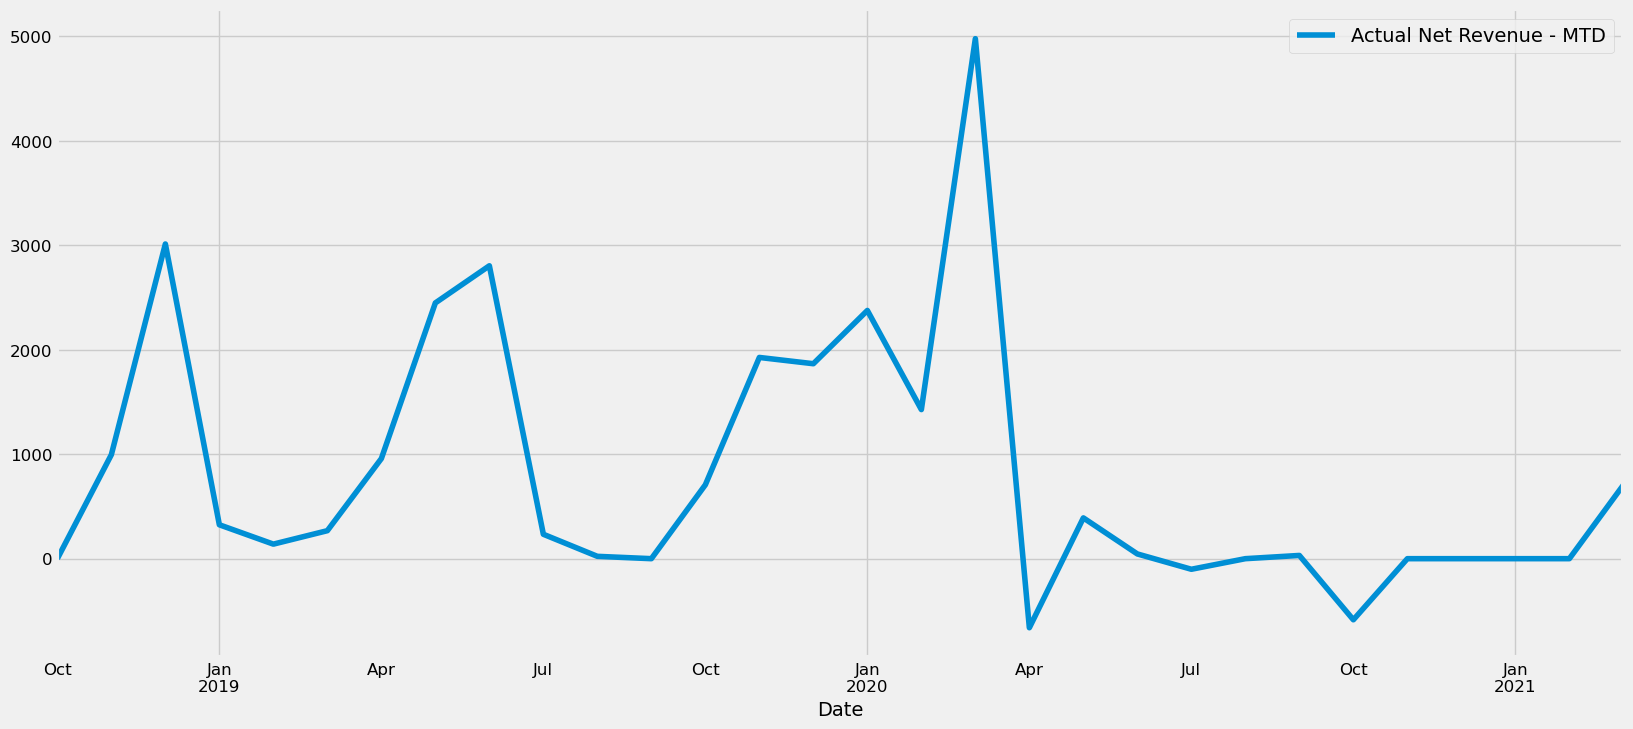

In [91]:
revenue_analysis('30004018', df_sub) #30004340 #30004337

In [45]:
df_30004018 = obtain_df('30004018', df_sub)

In [54]:
#Generate plot analysis 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

def decomposition_plot(project_number, sector, df):
    df_pn= df[df['Project Number'] == project_number]
    df_pn = df_pn[['Date', 'Actual Net Revenue - MTD']].copy()
    df_pn = df_pn.set_index('Date')
    decomposition = sm.tsa.seasonal_decompose(df_pn, model='additive')
    fig = decomposition.plot()
    return print(f" Selected Project Number: {project_number}"), print(f" Sector: {sector}"), plt.show()

In [55]:
#Extracting random samples from the dataframe with 27 observations
def random_project(df):
    df_x = df.sample(n=1)
    project_number = df_x['Project Number'].item()
    return project_number

In [56]:
random_project(df_sub)

'30017415'

In [57]:
def random_project_analysis(df):
    df_x = df.sample(n=1)
    project_number = df_x['Project Number'].item()
    sector = df_x['Ultimate Customer AUS Market Sector'].item()
    return decomposition_plot(project_number, sector, df)

In [58]:
def selected_project_analysis(project, df):
    df_x = df[df['Project Number'] == project]
    sector = df_x['Ultimate Customer AUS Market Sector'].iloc[-1]
    return decomposition_plot(project, sector, df)

 Selected Project Number: 30016138
 Sector: Oil & Gas


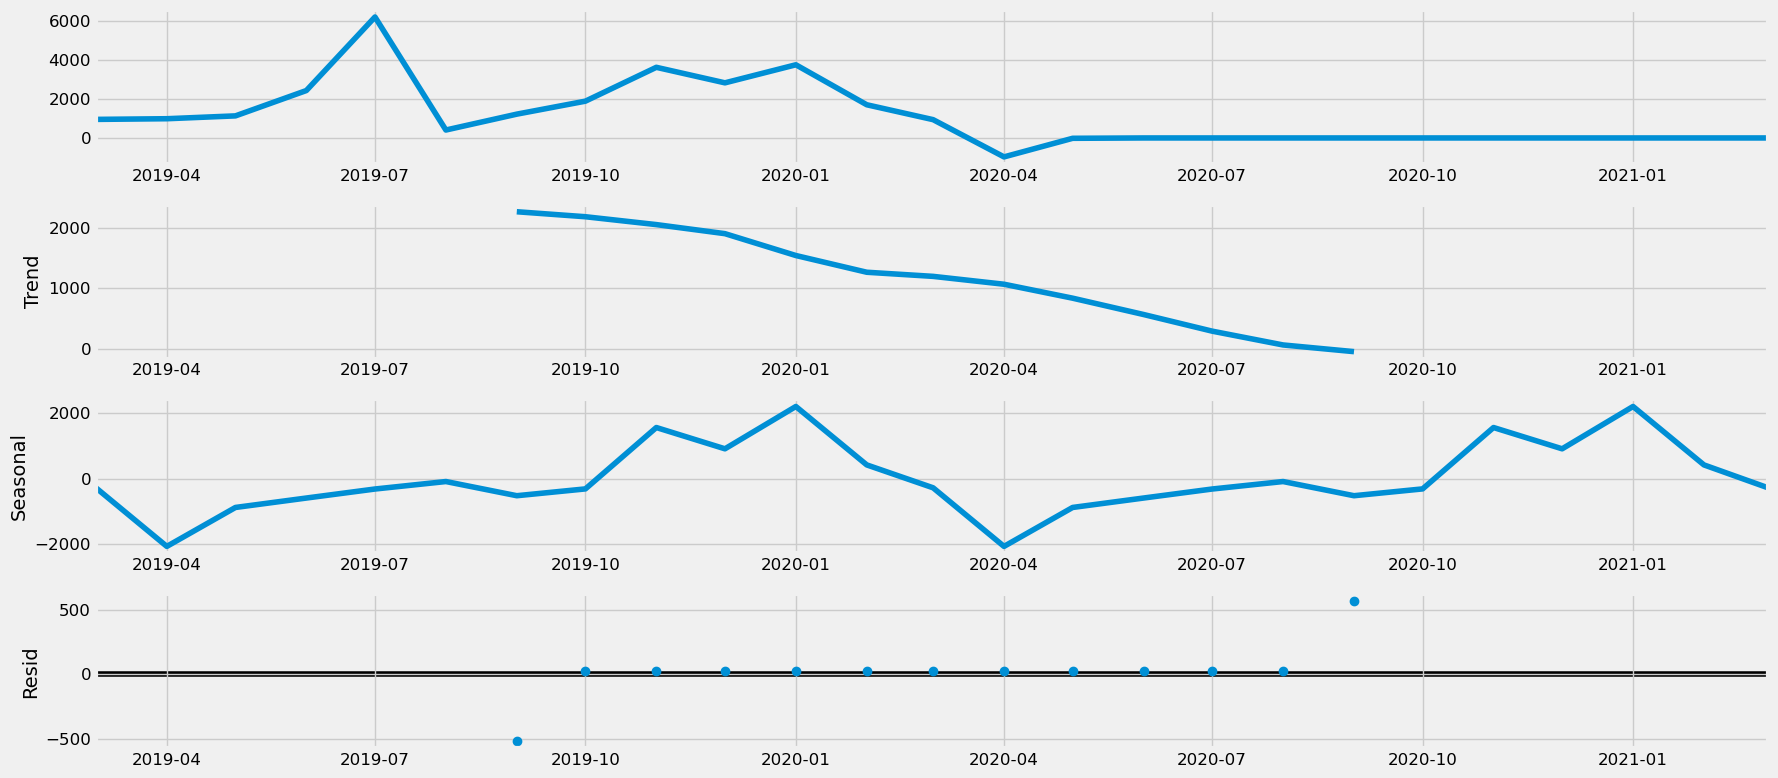

(None, None, None)

In [62]:
random_project_analysis(df_sub)

 Selected Project Number: 30010238
 Name: DE000442.0005-CSXT/LIVERNOIS YARD CLOSURE IN
 Sector: Rail


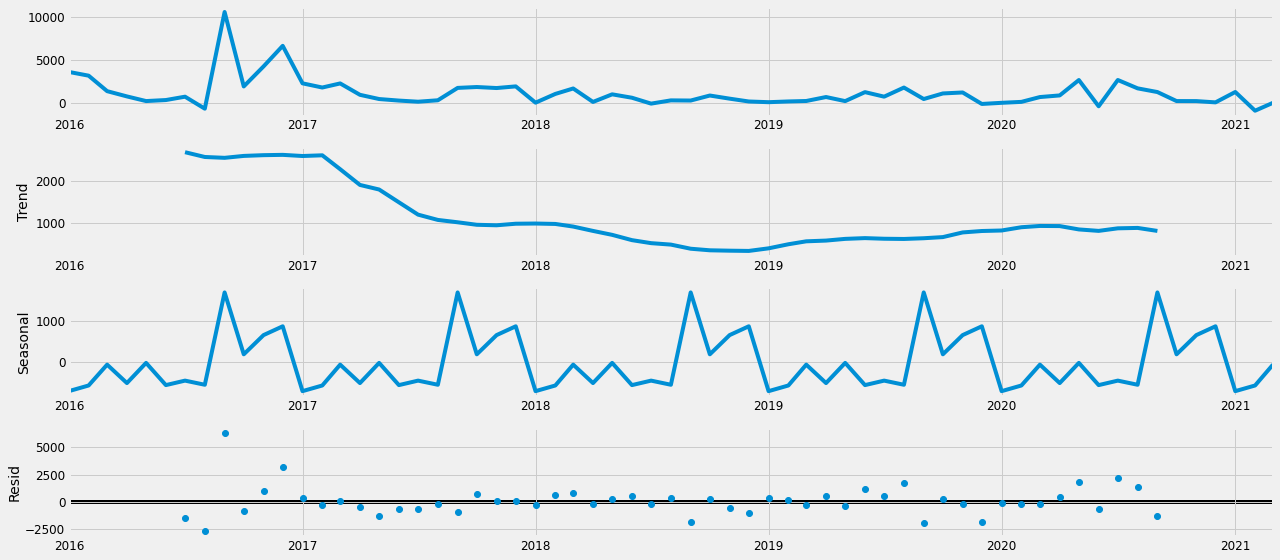

(None, None, None, None)

In [99]:
selected_project_analysis('30010238')

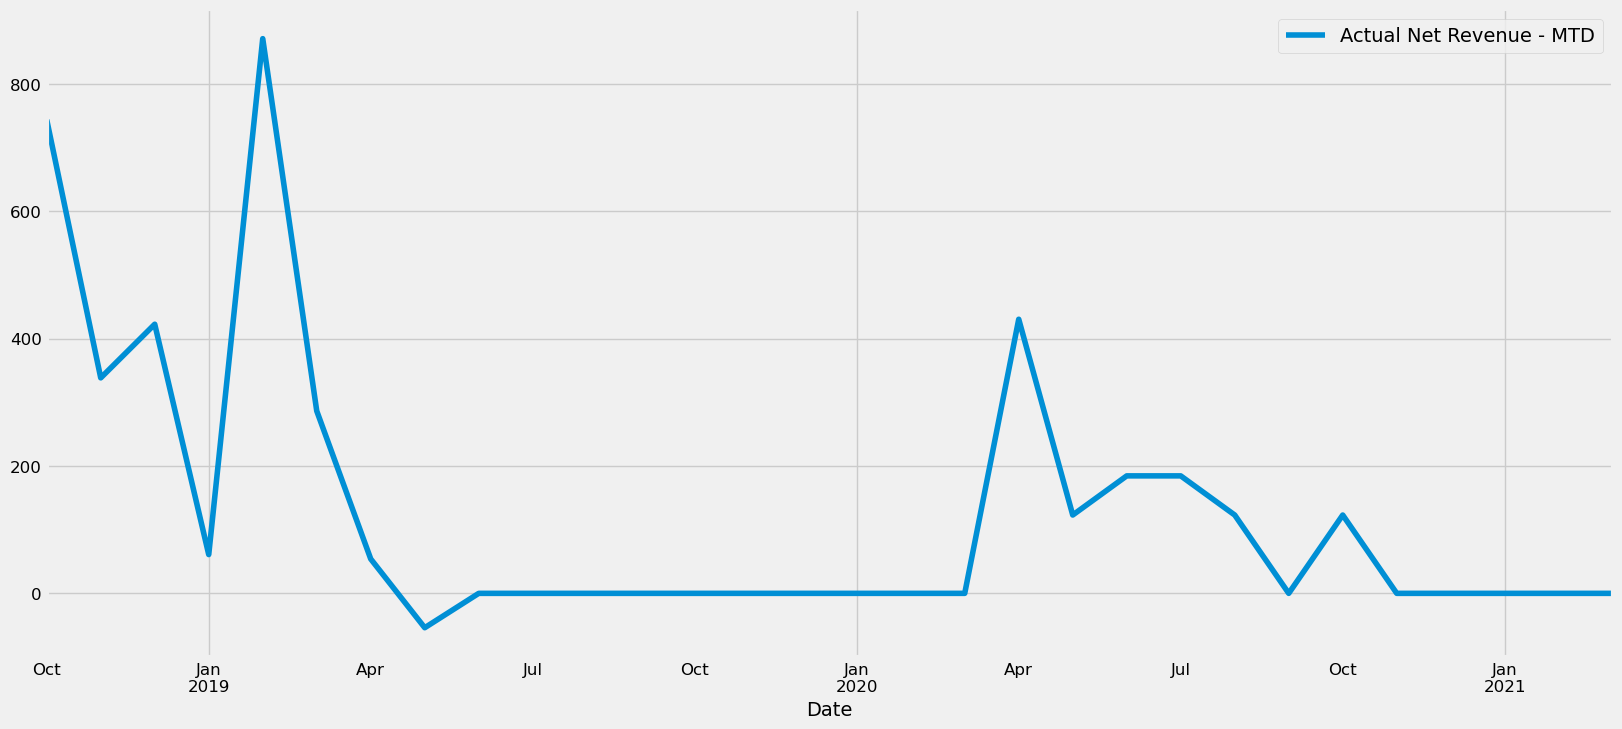

In [63]:
revenue_analysis('30009984', df_sub)

### Time Series using SARIMAX
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data. Akaike information criterion can be used to evaluate the best parameters. p is the number of previous time steps that will be considered. There is a value called “q” in the moving average model that is the order. In SARIMAX, we even take into account the seasonality of the pattern

In [64]:
def obtain_timeseries(project, df):
    df_pn = obtain_df(project, df)
    df_pn = df_pn[['Date', 'Actual Net Revenue - MTD']].copy()
    df_pn = df_pn.set_index('Date')
    return df_pn

In [65]:
x=random_project(df_sub)
x

'30011150'

In [66]:
some_df =obtain_timeseries('30010372', df_sub) #'30013631' df_30013631

In [67]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [68]:
# This is simulating a grid search for the most optimal parameters? 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(some_df, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            

#Fit the model with the best parameters
mod = sm.tsa.statespace.SARIMAX(some_df,
                                order=(5, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False) 
results = mod.fit()
print(results.summary().tables[1])

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1410.7479590698895
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:976.8553785898157
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1111.7866806794884
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:756.9635578789163
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1005.6421119325483
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:979.9144819109923
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:791.3356958406252
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:754.9490066565593
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1338.1713546087128
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1058.878155261386
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1067.9093448755334
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:789.4140438064039
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1103.4298195641263
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:887.0383795204112
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:785.5519970754619
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:788.8216537442054
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1203.7539531748525
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:913.5254456286881
ARI

In [69]:
import statsmodels.api as sm
import itertools

# Grid Search
p = d = q = range(0,2) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 12 # here I use twelve but the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
aics = []
# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(some_df, order=combination, seasonal_order=seasonal_combination)
                                             #enforce_stationarity=False,
                                             #enforce_invertibility=False)
            model = model.fit()
            combs.update({model.aic : [combination, seasonal_combination]})
            aics.append(model.aic)
            
        except:
            continue
            
best_aic = min(aics)

# Modeling and forcasting
model = sm.tsa.statespace.SARIMAX(some_df, order=combs[best_aic][0], seasonal_order=combs[best_aic][1])
                                             #enforce_stationarity=False,
                                             #enforce_invertibility=False)
results = model.fit()
results.forecast(7)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8153      0.145     -5.625      0.000      -1.099      -0.531
ma.L1          0.5370      0.218      2.462      0.014       0.109       0.965
ma.S.L12      -0.5657      0.101     -5.612      0.000      -0.763      -0.368
sigma2      1.476e+07    5.3e-09   2.79e+15      0.000    1.48e+07    1.48e+07


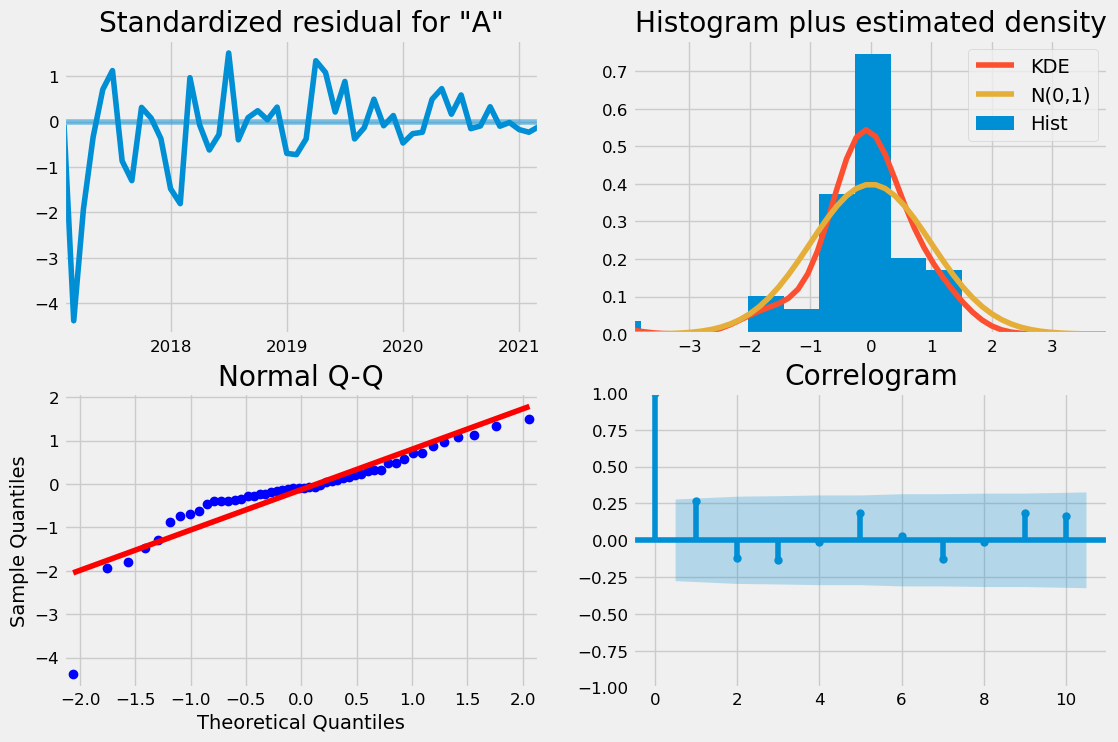

In [76]:
# if doesn't work, change 3 to 2
results.plot_diagnostics(figsize=(12, 8))
plt.show()

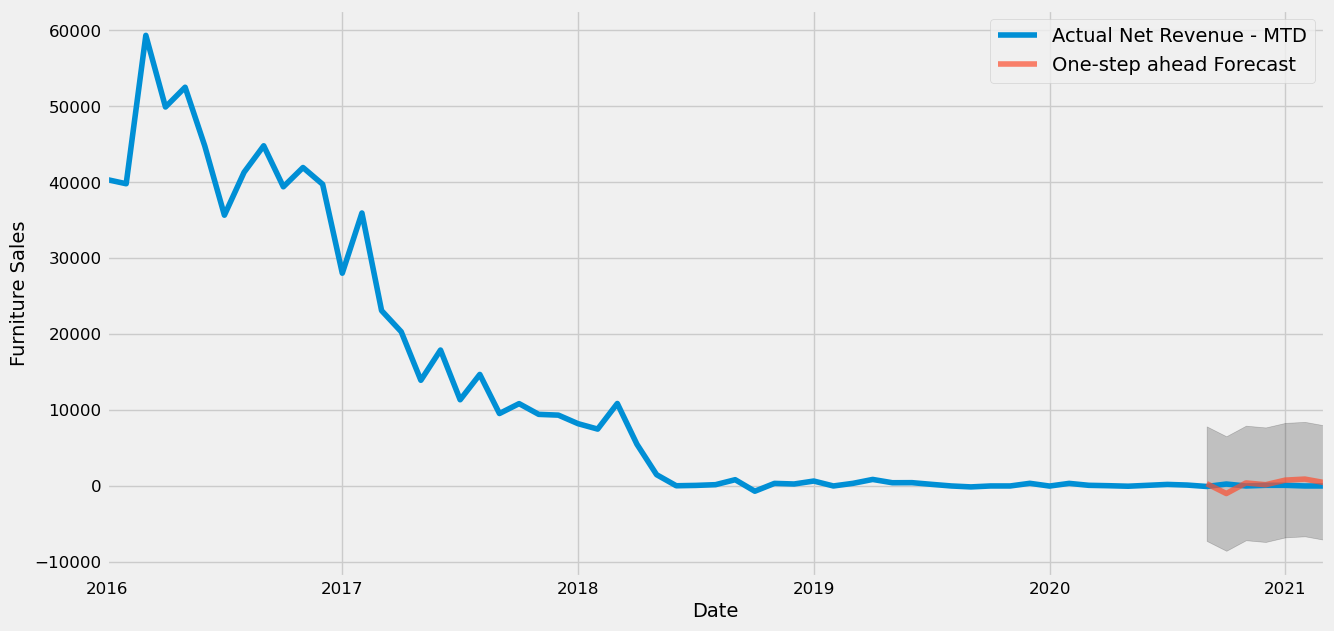

In [77]:
pred = results.get_prediction(start=pd.to_datetime('2020-09'), dynamic=False)
pred_ci = pred.conf_int()
ax = some_df['2016-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Actual Net Revenue')
plt.legend()
plt.show()

In [78]:
y_forecasted = pred.predicted_mean
y_truth = some_df['2020-09':]
y_truth = pd.Series(y_truth['Actual Net Revenue - MTD'].values, index=y_truth.index)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 477502.33


### Root Mean squared Error 
can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. The model can forecast the sales within RMSE of the real test set, given the range of the test set

In [94]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 691.02


In [82]:
def performance_comparison(x, df):
    another_df = obtain_df(x, df)
    y_forecasted = pred.predicted_mean.to_frame()
    plt.figure(figsize=(20, 8))
    plt.plot(another_df['Date'], another_df['Actual Net Revenue - MTD'], 'b-', label = 'Actual Revenue')
    plt.plot(another_df['Date'], another_df['Backlog_Shifted'], 'r-', label = 'Backlog Forecast')
    plt.plot(y_forecasted.index, y_forecasted['predicted_mean'], 'g-', label = 'Prediction SARIMAX model')
    plt.xlabel('Date'); plt.ylabel('Revenue'); plt.title('Performance comparison')
    plt.legend();
    return plt.show()

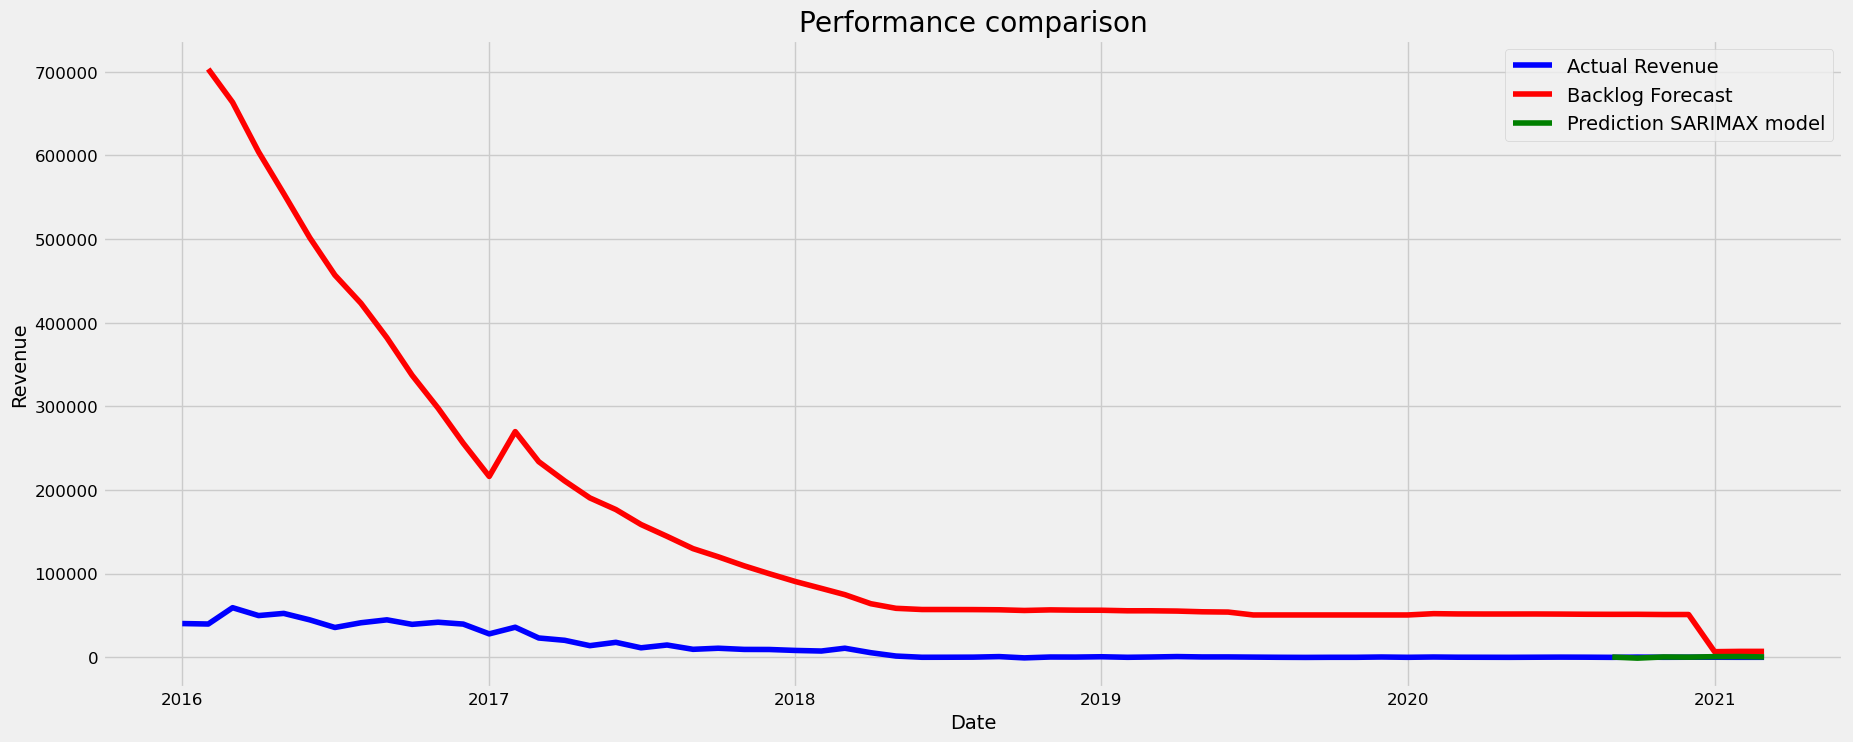

In [83]:
performance_comparison('30010372', df_sub)

### Time Series using ARIMA
Befire we used a SARIMAX, but there is certainly no seasonality in each project

In [341]:
from statsmodels.tsa.arima_model import ARIMA
import itertools
# Grid Search
p = d = q = range(0,5) # p, d, and q between 0-4
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q
combs = {} # stores aic and order pairs
aics = [] # stores aics
# Grid Search continued
for combination in pdq:
    try:
        model = ARIMA(some_df, order=combination) # create all possible models
        model = model.fit()
        combs.update({model.aic : combination}) # store combinations
        aics.append(model.aic)
    except:
        continue
        
best_aic = min(aics)
# Model Creation and Forecasting
model = ARIMA(some_df, order=combs[best_aic])
model = model.fit()
pred = model.forecast(7)[0]
print(type(best_aic), type(combs[best_aic]))

<class 'float'> <class 'tuple'>


In [300]:
y_forecasted = pred
y_truth = some_df['2020-09':]
y_truth = pd.Series(y_truth['Actual Net Revenue - MTD'].values, index=y_truth.index)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1786210.66


In [301]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 1336.49


In [325]:
def performance_comparison_arima(x, df):
    another_df = obtain_df(x, df)
    b=another_df.iloc[-7:,:1].values
    b= b.reshape(7,)
    df_forecast = pd.DataFrame({'Date':b, 'Prediction': y_forecasted})
    plt.figure(figsize=(20, 8))
    plt.plot(another_df['Date'], another_df['Actual Net Revenue - MTD'], 'b-', label = 'Actual Revenue')
    plt.plot(another_df['Date'], another_df['Backlog_Shifted'], 'r-', label = 'Backlog Forecast')
    plt.plot(df_forecast['Date'], df_forecast['Prediction'], 'g-', label = 'Prediction ARIMA Model')
    plt.xlabel('Date'); plt.ylabel('Revenue'); plt.title('Performance comparison')
    plt.legend();
    return plt.show()

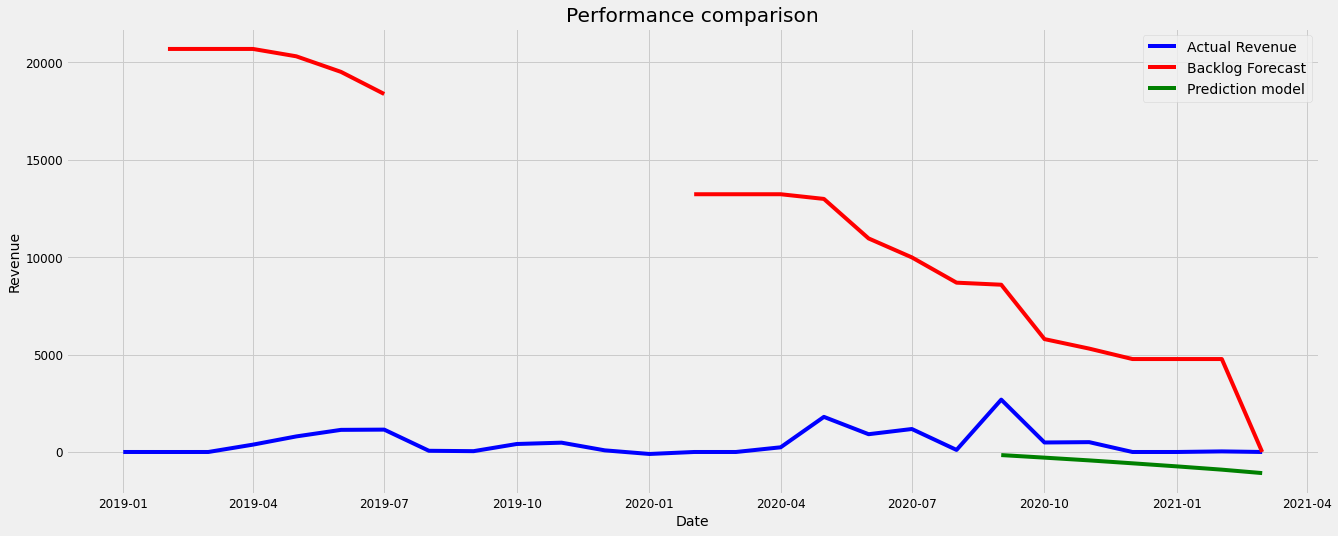

In [326]:
performance_comparison_arima(x, df_sub)

### Now we forecast with SARIMAX and exogenious variables
Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)
array-type structure with dimensions nobsxk where nobs is the number of your endogenous observations (i.e. supposing that you have a time series, the length of your time series) and k the number of your additional exogenous variables

##### first we need to encode the the variables to dummy

In [127]:
Project_Status = pd.get_dummies(df_sub['Project Status'], drop_first=True)
Contract_Name = pd.get_dummies(df_sub['Contract Type Name'], drop_first=True)
Ultimate_AUS = pd.get_dummies(df_sub['Ultimate Customer AUS Market Sector'], drop_first=True)
Divison = pd.get_dummies(df_sub['Division Short Name'], drop_first=True)
#Region = pd.get_dummies(df_sub['Region'], drop_first=True)
Proj_CVP = pd.get_dummies(df_sub['Proj_CVP'], drop_first=True)
Proj_Serv_Offering = pd.get_dummies(df_sub['Proj_Serv_Offering'], drop_first=True)
Client = pd.get_dummies(df_sub['primary_client_industry'], drop_first=True)
Aggregate_AUS = pd.get_dummies(df_sub['AUS Mkt Sector Aggregate'], drop_first=True)
Orgsize = pd.get_dummies(df_sub['Organization Size'], drop_first=True)
Profile = pd.get_dummies(df_sub['Risk Profile'], drop_first=True)



df_sub = pd.concat([df_sub, Project_Status], axis=1)
df_sub = pd.concat([df_sub, Contract_Name], axis=1)
df_sub = pd.concat([df_sub, Ultimate_AUS], axis=1)
df_sub = pd.concat([df_sub, Divison], axis=1)
#df_sub = pd.concat([df_sub, Region], axis=1)
df_sub = pd.concat([df_sub, Proj_CVP], axis=1)
df_sub = pd.concat([df_sub, Proj_Serv_Offering], axis=1)
df_sub = pd.concat([df_sub, Client], axis=1)
df_sub = pd.concat([df_sub, Aggregate_AUS], axis=1)
df_sub = pd.concat([df_sub, Orgsize], axis=1)
df_sub = pd.concat([df_sub, Profile], axis=1)

df_sub = df_sub.drop(columns=['Project Status', 'Contract Type Name', 'Ultimate Customer AUS Market Sector', 'Division Short Name',
                              'Proj_CVP', 'Proj_Serv_Offering', 'primary_client_industry', 'AUS Mkt Sector Aggregate', 'Organization Size', 'Risk Profile'])

In [128]:
sample2=obtain_df('30010372', df_sub) # #30048008

In [129]:
sample2

,Date,Project Number,Actual Net Revenue - MTD,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,EBITA - MTD,Forecast Direct Labor Cost - ITC,...,Key Global,Key Local,Key Regional,Local,RKC,Unspecified,Low,Medium,Unspecified,Backlog_Shifted
0,2016-01-01,30010372,40350.21,1845318,703376.37,14848.43,NaN,40520.20,3046.50,646319.17,...,0,0,0,1,0,0,1,0,0,NaN
1,2016-02-01,30010372,39785.81,1845318,663590.56,14610.18,NaN,39785.81,3080.65,646319.17,...,0,0,0,1,0,0,1,0,0,703376.37
2,2016-03-01,30010372,59321.31,1845318,604269.25,21690.36,NaN,59321.31,4828.62,646319.17,...,0,0,0,1,0,0,1,0,0,663590.56
3,2016-04-01,30010372,49887.90,1845318,554381.35,18775.41,NaN,50273.27,2718.44,646319.17,...,0,0,0,1,0,0,1,0,0,604269.25
4,2016-05-01,30010372,52490.86,1845318,501742.21,19464.46,NaN,52490.86,3590.30,645127.21,...,0,0,0,1,0,0,1,0,0,554381.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2020-11-01,30010372,0.00,1845318,51147.89,0.00,0.0,0.00,0.00,659287.42,...,0,0,0,1,0,0,1,0,0,51147.89
59,2020-12-01,30010372,84.87,1845318,6723.52,40.26,0.0,84.87,-7.33,641746.09,...,0,0,0,1,0,0,1,0,0,51147.89
60,2021-01-01,30010372,84.87,1845318,7073.60,40.26,0.0,84.87,-6.12,641915.89,...,0,0,0,1,0,0,1,0,0,6723.52
61,2021-02-01,30010372,0.00,1845318,7073.60,9.25,0.0,0.00,-20.90,641915.89,...,0,0,0,1,0,0,1,0,0,7073.60


In [130]:
sample2['scheduled_duration'] = sample2.scheduled_duration.str.replace('days' , '')
sample2['scheduled_duration'] = sample2.scheduled_duration.astype('int')
sample2.fillna(0, inplace=True)

In [131]:
## Then we prepare the samples an split them up
from sklearn.model_selection import TimeSeriesSplit
Y = sample2['Actual Net Revenue - MTD']
X = sample2.iloc[:, 3:]


X = np.array(X, dtype=float)
Y = np.array(Y, dtype=float)

total = len(Y)
ind = int(total*0.7)


X_train = X[:ind]
X_test = X[ind:]
Y_train = Y[:ind]
Y_test = Y[ind:]

In [133]:
# SARIMAX example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
import numpy as np

# fit model
model = SARIMAX(Y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), trend='n')
model_fit = model.fit(disp=False)
# make prediction

start_index = len(Y_train)
end_index = start_index + len(Y_test) -1

forecast = model_fit.predict(start=start_index, end=end_index, exog=X_test)


print(forecast)

[-8.05802580e+01  4.21407414e+01 -2.34832094e+00  3.82147016e+02
 -1.32660445e+02  2.18016069e+02 -4.24124596e+01 -6.82351659e+01
 -1.40698370e+02 -1.19809362e+01  1.42140735e+02  4.90966296e+01
 -1.14086691e+02  2.23590928e+02 -4.69088432e+01  5.28409817e+03
  4.68958323e+03  4.60411959e+03  4.60277978e+03]


### Root mean squared error

In [1]:
mse = ((Y_test - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

NameError: name 'Y_test' is not defined

In [135]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2185.05


### VARMAX model

In [10]:
X_train

NameError: name 'X_train' is not defined